# Causal Analysis of Sensor Dataset

In [1]:
%load_ext autoreload
%autoreload 2
import networkx as nx
import numpy as np
import pandas as pd
import scipy
import random
import seaborn as sns
from joblib import Parallel, delayed

from utils import treatment_effect, xray_util

sns.set_context("notebook")
%matplotlib inline

random.seed(0)
np.random.seed(0)

TREATMENT_COL = 'voltage_0'
treatment_subdimensions = ['voltage_1']
TREATMENT_VAL = '(2.6, 3.0]'

OUTCOME_NAME = 'truth'

CONT_COVARIATES = ['time_1']

TREATMENT = 'T'
OUTCOME = 'O'

In [2]:
dataset = xray_util.read_xray_input('data/sensor-temperature-10-50-balance1-input.txt', ['time', 'moteid', 'humidity', 'light', 'voltage'])

In [3]:
dataset[TREATMENT] = (dataset[TREATMENT_COL] == TREATMENT_VAL) | (dataset[TREATMENT_COL] == '(3.0, inf]')
dataset.rename({OUTCOME_NAME: OUTCOME}, axis=1, inplace=True)

COVARIATES = dataset.drop([TREATMENT, OUTCOME, TREATMENT_COL] + treatment_subdimensions, axis=1).columns.values
CAT_COVARIATES = list(c for c in COVARIATES if c not in CONT_COVARIATES)

## Analysis with Matching and Propensity Score Stratification

In [4]:
dataset.head()

,moteid,humidity,light,time_0,time_1,voltage_0,voltage_1,O,T
0,1.0,"(-inf, 0.0]","(1.0, 20.0]",NIGHT,03,"(-inf, 2.0]",2.0,True,False
1,1.0,"(35.0, 40.0]","(20.0, 50.0]",NIGHT,00,"(2.6, 3.0]",2.7,False,True
2,1.0,"(35.0, 40.0]","(20.0, 50.0]",NIGHT,01,"(2.6, 3.0]",2.7,False,True
3,1.0,"(35.0, 40.0]","(20.0, 50.0]",NIGHT,01,"(2.6, 3.0]",2.7,False,True
4,1.0,"(35.0, 40.0]","(20.0, 50.0]",NIGHT,01,"(2.6, 3.0]",2.7,False,True


In [5]:
excludes = ['moteid', 'light', 'humidity']
match_vars = []
att = treatment_effect.match_then_stratify(dataset, match_vars, TREATMENT, TREATMENT_COL, treatment_subdimensions,
                                           OUTCOME, CONT_COVARIATES, CAT_COVARIATES, n_models=10, additional_excludes=excludes)
att

Training model 1/10
Training model 2/10
Training model 3/10
Training model 4/10
Training model 5/10
Training model 6/10
Train Accuracy:  0.7977775505303849


C:\Users\Amnesix\DOCUME~1\KIT---~1\00-AUS~1\Studium\WINTER~1\CAUSAL~1\mldcpy\lib\site-packages\pandas\core\computation\expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


Covariate moteid not balanced enough in stratum 0 (chi2 55042.46021006602, p-value 0.0)
Covariate moteid not balanced enough in stratum 1 (chi2 50935.59765096303, p-value 0.0)
Covariate moteid not balanced enough in stratum 2 (chi2 42614.567003244716, p-value 0.0)
Covariate moteid not balanced enough in stratum 3 (chi2 44747.53177666269, p-value 0.0)
Covariate moteid not balanced enough in stratum 4 (chi2 33587.279467192224, p-value 0.0)
Covariate humidity not balanced enough in stratum 0 (chi2 15535.003438395252, p-value 0.0)
Covariate humidity not balanced enough in stratum 1 (chi2 23490.37196796123, p-value 0.0)
Covariate humidity not balanced enough in stratum 2 (chi2 80773.06012576164, p-value 0.0)
Covariate humidity not balanced enough in stratum 3 (chi2 101401.96612671744, p-value 0.0)
Covariate humidity not balanced enough in stratum 4 (chi2 78112.31940763017, p-value 0.0)
Covariate light not balanced enough in stratum 0 (chi2 11607.952420964408, p-value 0.0)
Covariate light no

-0.22812541423279703

#### Get statistical significance by comparing with placebo treatment

In [6]:
n_iter = 10
placebo_results = treatment_effect.generate_placebo_effects(dataset.sample(frac=0.5), match_vars, TREATMENT, TREATMENT_COL, treatment_subdimensions,
                                                            OUTCOME, CONT_COVARIATES, CAT_COVARIATES, additional_excludes=excludes, n_iter=n_iter)

In [7]:
treatment_effect.check_treatment_effect(att, placebo_results)

Treatment effect outside 95%-bounds of placebo effect: -0.22812541423279703 not in [-0.00132188893903277, 0.0007647803159951549]


In [8]:
treatment_results = Parallel(n_jobs=4)(delayed(treatment_effect.match_then_stratify)(dataset.sample(frac=1, replace=True), match_vars, TREATMENT, 
                                                                                     TREATMENT_COL, treatment_subdimensions, OUTCOME, CONT_COVARIATES, 
                                                                                     CAT_COVARIATES, additional_excludes=excludes, n_models=2) for _ in  range(n_iter))

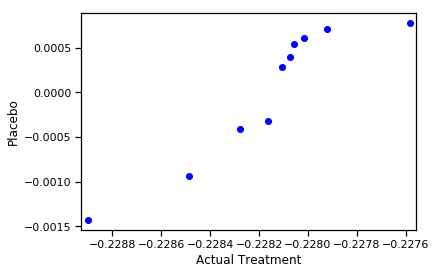

In [15]:
# QQ-Plot to compare empirical distributions.
from statsmodels.graphics.gofplots import qqplot_2samples
import pylab
import matplotlib.pyplot as plt

f = qqplot_2samples(np.array(placebo_results), np.array(treatment_results), xlabel='Actual Treatment', ylabel='Placebo')

In [10]:
treatment_effect.ks_test_treatment_effect(placebo_results, treatment_results, n_iter, alpha=0.05)

Rejecting hypothesis that placebo treatment and actual treatment are of same distribution (K-S statistic: 1.00000, p-value: 1.8879793657162556e-05)
